In [7]:
import pickle
from parameters.params import Params,Datasets,Models,Tasks
from util.env import set_param
from main import Main
import torch
from models.mine.MSTGAT import MSTGAT
from test_loop import test
from train_loop import train
import pandas as pd
from evaluate import IqrThreshold,MyConfusuion,IqrSensorThreshold,MinMaxThreshold,ZscoreThreshold


In [8]:
path = "./snapshot/my_mstgat_batadal_noconst/25_06_05_07_58_01/0/"

param: Params = pickle.load(file=open(f"{path}param.pickle", "rb"))
param.summary()

'### ./snapshot/my_mstgat_batadal_noconst/25_06_05_07_58_01/0/best.pt\n\n#### Params\n\n     NO EXTRA PARAMETERS.\n\n\n\n     PARAMETERS :\n\n|   batch |     dataset     |   datasetLoader |   decay |  device  |\n|---------|-----------------|-----------------|---------|----------|\n|      32 | batadal_noconst |               2 |       0 |   cuda   |\n\n|   embedding_dimension |   epoch |   learning_rate |   lstm_hidden_dim |   lstm_layers_num |\n|-----------------------|---------|-----------------|-------------------|-------------------|\n|                    32 |      60 |           0.001 |                64 |                 1 |\n\n|           model           |   out_layer_inter_dim |   out_layer_num |   random_seed |                        save_path                         |\n|---------------------------|-----------------------|-----------------|---------------|----------------------------------------------------------|\n| models.mine.MSTGAT.MSTGAT |                    32 |          

In [9]:
param.val_ratio=0
set_param(param)
print(param.task)

Tasks.next_sensors


In [10]:
model_parameters={}
if param.model in [Models.my_mstgat,Models.my_mstgat2]:
    model_parameters = {"gamma1": 0.5, "gamma2": 0.8, "kernel_size": 16}

In [11]:
main = Main(param=param,modelParams=model_parameters)
# main.load_leastTrain()

# DATASET 

*Datasets.batadal_noconst*
Model is trained. Loading from file .....


In [12]:
print(len(main.train_dataloader),len(main.val_dataloader),len(main.test_dataloader))

274 0 131


## Train losses
get all losses from train data loader

In [ ]:
train_all_loss,_,_ = test(main.model,main.train_dataloader,None)
train_all_loss.shape

## Test losses

In [47]:
test_all_losses,ys,lbls = test(main.model, main.test_dataloader,confusion=None)


## IqrThreshold
From all losses get the threshold And confusion metrics.
Based onthe threshold and confusion, get the real output of test

In [ ]:
thr=IqrSensorThreshold()
thr.fit(train_all_loss)
conf=MyConfusuion(thr=thr).to(device=param.device)
print("test_all_losses.shape: ",test_all_losses.shape)
conf.update(test_all_losses,lbls)
confusion_matrix=conf.compute()
confusion_matrix

## MinMaxThreshold

In [52]:

mmthr=MinMaxThreshold(multiplier=.95)
mmthr.fit(train_all_loss)
preds=mmthr.transform(test_all_losses)
mmConf=MyConfusuion(thr=mmthr).cuda()
mmConf.update(test_all_losses,lbls)
mmConf.compute()

tensor([[3872,   69],
        [   0,  219]], device='cuda:0')

<Axes: xlabel='m'>

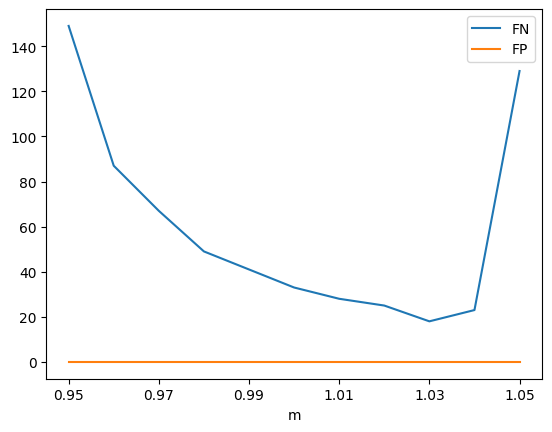

In [86]:
dft=pd.DataFrame({"FN":[],"FP":[],"m":[]})
for m in torch.arange(start=.95,step=.01,end=1.05):
    mxthr=MinMaxThreshold(multiplier=m)
    mxthr.fit(train_all_loss)
    mpreds=mxthr.transform(test_all_losses)
    mxConf=MyConfusuion(thr=mxthr).cuda()
    mxConf.update(test_all_losses,lbls)
    mtr=mxConf.compute().cpu().numpy()
    dft.loc[len(dft)]=[mtr[0][1],mtr[1][0],m.numpy()]
dft.plot(x="m")

In [ ]:
mmthr=ZscoreThreshold(threshold=3.42)
mmthr.fit(train_all_loss)
preds=mmthr.transform(test_all_losses)
mmConf=MyConfusuion(thr=mmthr).cuda()
mmConf.update(test_all_losses,lbls)
mmConf.compute()

In [ ]:
dft=pd.DataFrame({"FN":[],"FP":[],"m":[]})
for m in torch.arange(start=.8,step=.01,end=3.8):
    mxthr=ZscoreThreshold(threshold=m)
    mxthr.fit(train_all_loss)
    mpreds=mxthr.transform(test_all_losses)
    mxConf=MyConfusuion(thr=mxthr).cuda()
    mxConf.update(test_all_losses,lbls)
    mtr=mxConf.compute().cpu().numpy()
    dft.loc[len(dft)]=[mtr[0][1],mtr[1][0],m.numpy()]
dft.plot(x="m")

## AbsMaxThreshold

In [ ]:
from evaluate import AbsMaxThreshold
mmthr=AbsMaxThreshold(multiplier=3.7)
mmthr.fit(train_all_loss)
preds=mmthr.transform(test_all_losses)
mmConf=MyConfusuion(thr=mmthr).cuda()
mmConf.update(test_all_losses,lbls)
mmConf.compute()

In [ ]:

dft=pd.DataFrame({"FN":[],"FP":[]})
for m in torch.arange(start=.5,step=.1,end=5):
    mxthr=AbsMaxThreshold(multiplier=m)
    mxthr.fit(train_all_loss)
    mpreds=mxthr.transform(test_all_losses)
    mxConf=MyConfusuion(thr=mxthr).cuda()
    mxConf.update(test_all_losses,lbls)
    mtr=mxConf.compute().cpu().numpy()
    dft.loc[len(dft)]=[mtr[0][1],mtr[1][0]]
dft.plot()

In [87]:
# mmthr=IqrSensorThreshold()
mmthr=MinMaxThreshold(multiplier=1.03)
mmthr.fit(train_all_loss)
preds=mmthr.transform(test_all_losses)

## PLOTTING


all test Datasets

<Axes: >

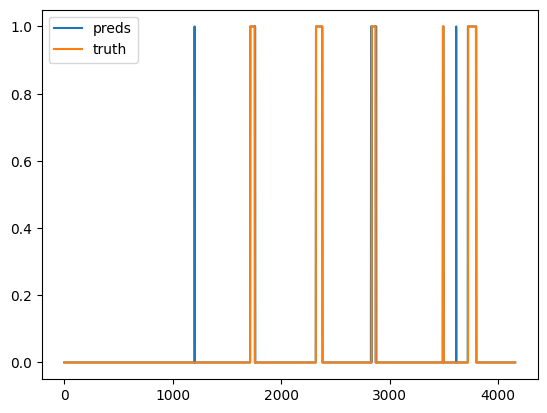

In [88]:

df=pd.DataFrame({"preds":preds.tolist(),"truth":lbls.tolist()})
df.plot()

Each attack zone


numebr of attacks =  219
First attack index is :  1715
Last attack index is :  3797
Number of attacks:  5
Minimum attack len:  6
Maximum attack len:  72
Mean attack len:  42.8


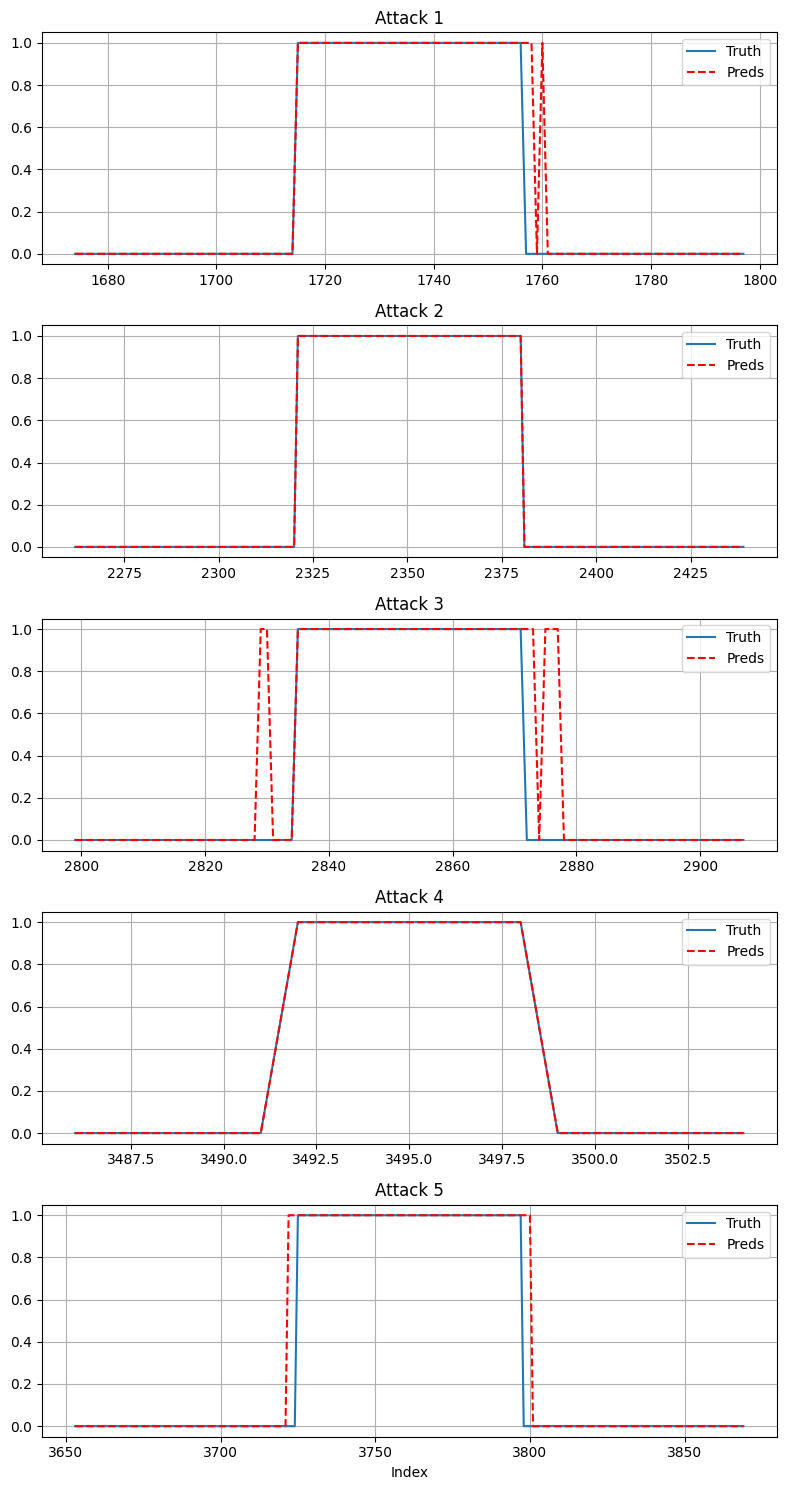

In [89]:
import matplotlib.pyplot as plt
from util.data import get_attack_interval,getAttacks


attacks=getAttacks(df,"truth")
# Identify contiguous regions of ones

# Create subplots dynamically
num_regions = len(attacks)
fig, axes = plt.subplots(num_regions, 1, figsize=(8, 3*num_regions), sharex=False)

if num_regions == 1:
    axes = [axes]  # Ensure axes is iterable

for i in range(num_regions):
    # first_idx = group.index.min()  # First occurrence of 1
    # last_idx = group.index.max()   # Last occurrence of 1
    [first_idx,last_idx]=attacks[i]
    range_before = first_idx - int(1.0 *(last_idx-first_idx))
    range_after = last_idx + int(1.0 *(last_idx-first_idx))
    if range_before<0:
        range_before=0
    if range_after>len(df):
        range_after=last_idx
    # df.iloc[first_idx:last_idx].plot(ax=ax)
    axes[i].plot( df.loc[range_before:range_after,'truth'], label="Truth")
    axes[i].plot( df.loc[range_before:range_after,'preds'], color='red', label="Preds",linestyle="--")

    # ax.set_xlim(range_before, range_after)  # X-axis limit dynamically adjusted
    # ax.set(ybound=(0, max(df['preds']) + 10))  # Corrected method for Y-axis limits

    axes[i].set_title(f"Attack {i+1}")
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel("Index")
plt.tight_layout()
plt.show()

In [ ]:
print("max: ",test_result[0].max(),
    #   val_result[0].max(),
      train_result[0].max())
print("min: ",test_result[0].min(),
    #   val_result[0].min(),
      train_result[0].min())


In [ ]:
from util.data import getAttacks

In [ ]:
minimum=0#val_result[0].min()
maximum=train_result[0].max().item()*1#*24.5

pred=torch.where((test_result[0]>maximum) ,torch.tensor(1),torch.tensor(0)).cpu().numpy()
labels_df=pd.DataFrame({"pred":pred,"truth":test_result[2].cpu().numpy()})
attacks=getAttacks(labels_df,"truth")


In [ ]:

for i,attack in enumerate(attacks):
    left=(attack[0]//100)*100
    right=((attack[1]//100)+1)*100
    labels_df.loc[left:right].plot(title=f"attack {i+1}")

In [ ]:
r=test_result[3].sum(-1)
print(r.max(),r.min(),r.mean())

In [ ]:
from evaluate import createMetrics
k=createMetrics(test_result,maximum)
print(k)
k.keys()

In [ ]:
k2=['TP', 'FP', 'TN', 'FN']
k1=["Accuracy","Precision","Recall","F1"]
d1={key:[] for key in k1}
d2={key:[] for key in k2}
x=[]
for i in range(100):
    _max=maximum*(.5+i/100)
    rr=createMetrics(test_result,_max)
    x.append(_max)
    for key  in d1.keys():
        d1[key].append(float(rr[key]))
    for key  in d2.keys():
        d2[key].append(float(rr[key]))